In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

import qiskit as qk
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
import qiskit.quantum_info as qi
import qiskit.circuit.library as ql

import random
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise


# Loading your IBM Q account(s)
provider = IBMQ.load_account()

## Gépek

In [2]:
simulator = qk.BasicAer.get_backend('qasm_simulator')
real1 = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 3,
                                            operational=True, simulator=False))
real2 = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 11,
                                            operational=True, simulator=False))

In [3]:
print(real2)

ibmq_16_melbourne


## A kvantumáramkörhöz használt kapuk összeállítása

In [4]:
def pgate(n):
    qc = QuantumCircuit(1)
    qc.p(np.pi/2**(n-1), 0)
    g = qc.to_gate()
    g.name = 'p{}'.format(n)
    return g
         

qc = QuantumCircuit(5)

#qc.append(pgate(2).control(1), range(2))
#qc.append(pgate(3).control(1), [0, 2])
#qc.h(1)

#qc.append(pgate(3).control(2), [0, 1, 3])
qc.append(ql.XGate().control(2), [0, 1, 4])
#qc.append(pgate(3).control(2), [0, 2, 5])
#qc.append(qft(3), range(3))
qc.draw()
s1 = qk.compiler.transpile(qc, simulator, optimization_level=1)
s2 = qk.compiler.transpile(qc, real2, optimization_level=3)
print(s1.depth(), s1.count_ops())
s1.draw()

11 OrderedDict([('cx', 6), ('u1', 6), ('u2', 2)])


global phase: 0
                                                                       »
q_0: ──────────────────────────────■────────────────────────────────■──»
                                   │                  ┌─────────┐   │  »
q_1: ─────────────■────────────────┼───────────────■──┤ U1(π/4) ├───┼──»
                  │                │               │  └─────────┘   │  »
q_2: ─────────────┼────────────────┼───────────────┼────────────────┼──»
                  │                │               │                │  »
q_3: ─────────────┼────────────────┼───────────────┼────────────────┼──»
     ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐»
q_4: ┤ U2(0,π) ├┤ X ├┤ U1(-π/4) ├┤ X ├┤ U1(π/4) ├┤ X ├┤ U1(-π/4) ├┤ X ├»
     └─────────┘└───┘└──────────┘└───┘└─────────┘└───┘└──────────┘└───┘»
«                    ┌─────────┐      
«q_0: ───────■───────┤ U1(π/4) ├───■──
«          ┌─┴─┐     ├─────────┴┐┌─┴─┐
«q_1: ─────┤ X ├─────┤ U1(-π/4) ├┤ X ├
«          └───┘     └──────────┘└───┘
«q_2: ────────────────────────────────
«                                     
«q_3: ────────────────────────────────
«     ┌─────────────┐                 
«q_4: ┤ U2(0,-3π/4) ├─────────────────
«     └─────────────┘

In [5]:
def qft(n): # 1 qubit: n, 2 qubit: n(n-1)/2
    qc = QuantumCircuit(n)
    for i in range(int(n/2)):
        qc.swap(i, n-i-1)
    for i in range(n):
        qc.h(i)
        for j in range(i+1, n):
            qc.cp(2*np.pi/2**(j-i+1), j, i)
    circ = qc.to_gate()
    circ.name = 'QFT{}'.format(n)
    return circ

In [145]:
def qft(qc,n): # 1 qubit: n, 2 qubit: n(n-1)/2
   # qc = QuantumCircuit(n)
    for i in range(int(n/2)):
        qc.swap(i, n-i-1)
    for i in range(n):
        qc.h(i)
        for j in range(i+1, n):
            qc.cp(2*np.pi/2**(j-i+1), j, i)
    return qc
qc = QuantumCircuit(3)
qft(qc, 3)
sc = qk.compiler.transpile(qc, simulator, optimization_level=1)
print(sc.depth(), sc.count_ops())
qc.draw()

16 OrderedDict([('u1', 9), ('cx', 9), ('u2', 3)])


┌───┐                                     
q_0: ─X─┤ H ├─■────────■──────────────────────────
      │ └───┘ │P(π/2)  │       ┌───┐              
q_1: ─┼───────■────────┼───────┤ H ├─■────────────
      │                │P(π/4) └───┘ │P(π/2) ┌───┐
q_2: ─X────────────────■─────────────■───────┤ H ├
                                             └───┘

In [6]:
def add(n, a): # klasszikus összeadó áramkör (ezt nem használja az algoritmus, a másik jobb)  kapuk: n(n+1)/2
    qc = QuantumCircuit(n)
    copy = a%(2**n)
    a_bin = []
    for i in range(n):
        a_bin.append(copy//2**(n-1-i))
        copy = copy%2**(n-1-i)
    for i in range(n):
        if a_bin[i] == 1:
            for j in range(i):
                qc.append(ql.XGate().control(i-j), range(n-i-1, n-j))
            qc.x(n-1-i)
    add = qc.to_gate()
    add.name = '{}add{}'.format(n, a)
    return add

def F_add(n, a): # összeadás Fourier bázisban (ezt használja az algoritmus)  kapuk: n(n+1)/2
    qc = QuantumCircuit(n)
    a_bin = []
    copy = a%(2**n)
    for i in range(n):
        a_bin.append(copy//2**(n-1-i))
        
        copy = copy % 2**(n-1-i)
    #qc.append(qft(n), range(n))
    rot = np.zeros(n)
    for i in range(n):
        if a_bin[n-i-1] == 1:
            for j in range(n-i):
                rot[n-j-i-1] += 2*np.pi/2**(j+1)
    for i in range(n):
        qc.p(rot[i], i)
    #qc.append(qft(n).inverse(), range(n))
    gate = qc.to_gate()
    gate.name = '{}F_add{}'.format(n, a)
    return gate

In [286]:
'''
def F_add(qc, n, a): # összeadás Fourier bázisban (ezt használja az algoritmus)  kapuk: n(n+1)/2
    #qc = QuantumCircuit(n)
    a_bin = []
    copy = a%(2**n)
    for i in range(n):
        a_bin.append(copy//2**(n-1-i))
        copy = copy%2**(n-1-i)
    #qc.append(qft(n), range(n))
    for i in range(n):
        if a_bin[n-i-1] == 1:
            for j in range(n-i):
                qc.p(2*np.pi/2**(j+1), n-j-i-1)
    #qc.append(qft(n).inverse(), range(n))
    return qc
'''
qc = QuantumCircuit(7)
qc.append(F_add(4, 7).control(2), range(6))
qc.append(F_add(4, 7).control(2), [0, 2, 3, 4, 5, 6])
#qc.append(F_add(4, 1).control(2), range(6))
#qc.append(F_add(5, 7), range(3))
sc = qk.compiler.transpile(qc, simulator, optimization_level=0)
print(sc.depth(), sc.count_ops())

qc.draw()

85 OrderedDict([('u1', 72), ('cx', 64)])


q_0: ─────■───────────■──────
          │           │      
q_1: ─────■───────────┼──────
     ┌────┴─────┐     │      
q_2: ┤0         ├─────■──────
     │          │┌────┴─────┐
q_3: ┤1         ├┤0         ├
     │  4F_add7 ││          │
q_4: ┤2         ├┤1         ├
     │          ││  4F_add7 │
q_5: ┤3         ├┤2         ├
     └──────────┘│          │
q_6: ────────────┤3         ├
                 └──────────┘

In [7]:
# 0, 1: control | range(2, n+2): addition | n+2, n+3: auxiliary
# adds in Fourier basis
def c2_mod_add(a, N): #csak akkor működik jól, ha az erediti szám < N (az algoritmushoz ez elég)
    n = N.bit_length()
    qc = QuantumCircuit(n+4)
    qc.append(F_add(n+1, a).control(2), range(n+3))
    qc.append(F_add(n+1, N).inverse(), range(2, n+3))
    qc.append(qft(n+1).inverse(), range(2, n+3))
    qc.cx(n+2, n+3)
    qc.append(qft(n+1), range(2, n+3))
    qc.append(F_add(n+1, N).control(), [n+3]+list(range(2, n+3)))
    qc.append(F_add(n+1, a).inverse().control(2), range(n+3))
    qc.append(qft(n+1).inverse(), range(2, n+3))
    qc.x(n+2)
    qc.cx(n+2, n+3)
    qc.x(n+2)
    qc.append(qft(n+1), range(2, n+3))
    qc.append(F_add(n+1, a).control(2), range(n+3))
    gate = qc.to_gate()
    gate.name = 'cadd{}mod{}'.format(a,N)
    return gate

In [293]:
def c2_mod_add(qc, a, N): #csak akkor működik jól, ha az erediti szám < N (az algoritmushoz ez elég)
    n = N.bit_length()
   # qc = QuantumCircuit(n+4)
    qc.append(F_add(n+1, a).control(2), range(n+3))
    qc.append(F_add(n+1, N).inverse(), range(2, n+3))
    qc.append(qft(n+1).inverse(), range(2, n+3))
    qc.cx(n+2, n+3)
    qc.append(qft(n+1), range(2, n+3))
    qc.append(F_add(n+1, N).control(), [n+3]+list(range(2, n+3)))
    qc.append(F_add(n+1, a).inverse().control(2), range(n+3))
    qc.append(qft(n+1).inverse(), range(2, n+3))
    qc.x(n+2)
    qc.cx(n+2, n+3)
    qc.x(n+2)
    qc.append(qft(n+1), range(2, n+3))
    qc.append(F_add(n+1, a).control(2), range(n+3))
    return qc

qc = QuantumCircuit(8)
c2_mod_add(qc, 3, 7)

sc = qk.compiler.transpile(qc, simulator, optimization_level=1)
print(sc.depth(), sc.count_ops())

qc.draw()


219 OrderedDict([('u1', 178), ('cx', 166), ('u2', 16), ('x', 2)])


»
q_0: ─────■───────────────────────────────────────────────────────────»
          │                                                           »
q_1: ─────■───────────────────────────────────────────────────────────»
     ┌────┴─────┐┌─────────────┐┌──────────┐     ┌───────┐┌──────────┐»
q_2: ┤0         ├┤0            ├┤0         ├─────┤0      ├┤0         ├»
     │          ││             ││          │     │       ││          │»
q_3: ┤1         ├┤1            ├┤1         ├─────┤1      ├┤1         ├»
     │  4F_add3 ││  4F_add7_dg ││  QFT4_dg │     │  QFT4 ││  4F_add7 │»
q_4: ┤2         ├┤2            ├┤2         ├─────┤2      ├┤2         ├»
     │          ││             ││          │     │       ││          │»
q_5: ┤3         ├┤3            ├┤3         ├──■──┤3      ├┤3         ├»
     └──────────┘└─────────────┘└──────────┘┌─┴─┐└───────┘└────┬─────┘»
q_6: ───────────────────────────────────────┤ X ├──────────────■──────»
                                            └───┘                     »
q_7: ─────────────────────────────────────────────────────────────────»
                                                                      »
«                                                                    
«q_0: ───────■────────────────────────────────────────────────■──────
«            │                                                │      
«q_1: ───────■────────────────────────────────────────────────■──────
«     ┌──────┴──────┐┌──────────┐               ┌───────┐┌────┴─────┐
«q_2: ┤0            ├┤0         ├───────────────┤0      ├┤0         ├
«     │             ││          │               │       ││          │
«q_3: ┤1            ├┤1         ├───────────────┤1      ├┤1         ├
«     │  4F_add3_dg ││  QFT4_dg │               │  QFT4 ││  4F_add3 │
«q_4: ┤2            ├┤2         ├───────────────┤2      ├┤2         ├
«     │             ││          │┌───┐     ┌───┐│       ││          │
«q_5: ┤3            ├┤3         ├┤ X ├──■──┤ X ├┤3      ├┤3         ├
«     └─────────────┘└──────────┘└───┘┌─┴─┐└───┘└───────┘└──────────┘
«q_6: ────────────────────────────────┤ X ├──────────────────────────
«                                     └───┘                          
«q_7: ───────────────────────────────────────────────────────────────
«

In [301]:
def c_mod_mult(qc, a, N): # a-val szoroz moduló N
    n = N.bit_length()
    #qc = QuantumCircuit(2*n+3)
    qc.append(qft(n+1), range(n+1, 2*n+2))
    for i in range(n):
        mod = a*(2**i) % N
        qc.append(c2_mod_add(mod, N), [0,i+1]+list(range(n+1, 2*n+3)))
    qc.append(qft(n+1).inverse(), range(n+1, 2*n+2))
    return qc
qc = QuantumCircuit(11)
c_mod_mult(qc, 11, 15)
sc = qk.compiler.transpile(qc, simulator, optimization_level=1)
print(sc.depth(), sc.count_ops())
qc.draw()

1097 OrderedDict([('u1', 1032), ('cx', 924), ('u2', 90), ('x', 8)])


┌──────────────┐┌─────────────┐┌──────────────┐┌──────────────┐»
 q_0: ─────────┤0             ├┤0            ├┤0             ├┤0             ├»
               │              ││             ││              ││              │»
 q_1: ─────────┤1             ├┤             ├┤              ├┤              ├»
               │              ││             ││              ││              │»
 q_2: ─────────┤              ├┤1            ├┤              ├┤              ├»
               │              ││             ││              ││              │»
 q_3: ─────────┤              ├┤             ├┤1             ├┤              ├»
               │              ││             ││              ││              │»
 q_4: ─────────┤              ├┤             ├┤              ├┤1             ├»
      ┌───────┐│              ││             ││              ││              │»
 q_5: ┤0      ├┤2 cadd11mod15 ├┤2 cadd7mod15 ├┤2 cadd14mod15 ├┤2 cadd13mod15 ├»
      │       ││              ││             ││              ││              │»
 q_6: ┤1      ├┤3             ├┤3            ├┤3             ├┤3             ├»
      │       ││              ││             ││              ││              │»
 q_7: ┤2 QFT5 ├┤4             ├┤4            ├┤4             ├┤4             ├»
      │       ││              ││             ││              ││              │»
 q_8: ┤3      ├┤5             ├┤5            ├┤5             ├┤5             ├»
      │       ││              ││             ││              ││              │»
 q_9: ┤4      ├┤6             ├┤6            ├┤6             ├┤6             ├»
      └───────┘│              ││             ││              ││              │»
q_10: ─────────┤7             ├┤7            ├┤7             ├┤7             ├»
               └──────────────┘└─────────────┘└──────────────┘└──────────────┘»
«                  
« q_0: ────────────
«                  
« q_1: ────────────
«                  
« q_2: ────────────
«                  
« q_3: ────────────
«                  
« q_4: ────────────
«      ┌──────────┐
« q_5: ┤0         ├
«      │          │
« q_6: ┤1         ├
«      │          │
« q_7: ┤2 QFT5_dg ├
«      │          │
« q_8: ┤3         ├
«      │          │
« q_9: ┤4         ├
«      └──────────┘
«q_10: ────────────
«

In [8]:
# 0: control | range(1, n+1): number to be multiplied | range(n+1, 2n+3): c_mod_add -> result
def c_mod_mult(a, N): # a-val szoroz moduló N
    n = N.bit_length()
    qc = QuantumCircuit(2*n+3)
    qc.append(qft(n+1), range(n+1, 2*n+2))
    for i in range(n):
        mod = a*(2**i) % N
        qc.append(c2_mod_add(mod, N), [0,i+1]+list(range(n+1, 2*n+3)))
    qc.append(qft(n+1).inverse(), range(n+1, 2*n+2))
    gate = qc.to_gate()
    gate.name = 'cmult{}mod{}'.format(a, N)
    return gate

In [9]:
def gcd(m, n): # euclid's algorithm
    a = max(m,n)
    b = min(m,n)
    if a%b == 0:
        return a, b
    c = a % b
    return gcd(b, c) # c a legnagyobb közös osztó

def mod_inv(a, N): # a and N have to be coprime
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    a = a%N
    k = [0, 1]
    m = [N, a]
    while m[1] != 1:
        tmp = m[0]
        p = tmp//m[1]
        m[0] = m[1]
        m[1] = tmp - p*m[1]
        tmp1 = k[0]
        k[0] = k[1]
        k[1] = tmp1 - p*k[1]
    return k[1]%N

In [10]:
def swap():
    qc = QuantumCircuit(2)
    qc.swap(0, 1)
    gate = qc.to_gate()
    gate.name = 'swap'
    return gate

# 0: control | range(1, n+1): number to be multiplied | range(n+1, 2n+3): auxiliary       
def c_U(a, N): # multiplies with 'a' mod N, 'a' and N have to be coprime
    n = N.bit_length()
    qc = QuantumCircuit(2*n+3)
    qc.append(c_mod_mult(a, N), range(2*n+3))
    for i in range(n):
        qc.append(swap().control(), [0, i+1, n+i+1])
    qc.append(c_mod_mult(mod_inv(a, N), N).inverse(), range(2*n+3))
    gate = qc.to_gate()
    gate.name = 'cU_{},{}'.format(N, a)
    return gate

In [314]:
def c_U(qc,a, N): # multiplies with 'a' mod N, 'a' and N have to be coprime
    n = N.bit_length()
    #qc = QuantumCircuit(2*n+3)
    qc.append(c_mod_mult(a, N), range(2*n+3))
    for i in range(n):
        qc.append(swap().control(), [0, i+1, n+i+1])
    qc.append(c_mod_mult(mod_inv(a, N), N).inverse(), range(2*n+3))
    return qc
qc = QuantumCircuit(11)
c_U(qc, 4, 15)
sc = qk.compiler.transpile(qc, simulator, optimization_level=1)
print(sc.depth(), sc.count_ops())
qc.draw()

1915 OrderedDict([('u1', 1826), ('cx', 1640), ('u2', 176), ('x', 16), ('u3', 4)])


┌───────────────┐            ┌──────────────────┐
 q_0: ┤0              ├─■──■──■──■─┤0                 ├
      │               │ │  │  │  │ │                  │
 q_1: ┤1              ├─X──┼──┼──┼─┤1                 ├
      │               │ │  │  │  │ │                  │
 q_2: ┤2              ├─┼──X──┼──┼─┤2                 ├
      │               │ │  │  │  │ │                  │
 q_3: ┤3              ├─┼──┼──X──┼─┤3                 ├
      │               │ │  │  │  │ │                  │
 q_4: ┤4              ├─┼──┼──┼──X─┤4                 ├
      │               │ │  │  │  │ │                  │
 q_5: ┤5  cmult4mod15 ├─X──┼──┼──┼─┤5  cmult4mod15_dg ├
      │               │    │  │  │ │                  │
 q_6: ┤6              ├────X──┼──┼─┤6                 ├
      │               │       │  │ │                  │
 q_7: ┤7              ├───────X──┼─┤7                 ├
      │               │          │ │                  │
 q_8: ┤8              ├──────────X─┤8                 ├
      │               │            │                  │
 q_9: ┤9              ├────────────┤9                 ├
      │               │            │                  │
q_10: ┤10             ├────────────┤10                ├
      └───────────────┘            └──────────────────┘

In [11]:
# az U operátor sajátfázisának közelítő értékét adja vissza
def Shor_phase_est(a, N, cbits=3): # cbits: 2*n+bits control qubitet használ
    n = N.bit_length()
    qc = QuantumCircuit(4*n+2+cbits)
    qc.x([2*n+cbits])
    qc.h(range(2*n+cbits))
    for i in range(2*n+cbits):
        mod = two_pow_mod(a, i, N)
        qc.append(c_U(mod, N), [2*n+cbits-1-i]+list(range(2*n+cbits, 4*n+2+cbits)))
    for i in range(n+cbits//2):
        qc.swap(i, 2*n+cbits-1-i)
    qc.append(qft(2*n+cbits).inverse(), range(2*n+cbits))
    gate = qc.to_gate()
    gate.name = 'phase_est'
    return gate

In [321]:
def Shor_phase_est(qc, a, N, cbits=3): # cbits: 2*n+cbits control qubitet használ
    n = N.bit_length()
    #qc = QuantumCircuit(4*n+2+cbits)
    qc.x([2*n+cbits])
    qc.h(range(2*n+cbits))
    for i in range(2*n+cbits):
        mod = two_pow_mod(a, i, N)
        qc.append(c_U(mod, N), [2*n+cbits-1-i]+list(range(2*n+cbits, 4*n+2+cbits)))
    for i in range(n+cbits//2):
        qc.swap(i, 2*n+cbits-1-i)
    qc.append(qft(2*n+cbits).inverse(), range(2*n+cbits))
    return qc

N=15
n= N.bit_length()
qc = QuantumCircuit(4*n+5)
Shor_phase_est(qc, 4, N)
sc = qk.compiler.transpile(qc, simulator, optimization_level=1)
print(sc.depth(), sc.count_ops())
qc.draw()


21006 OrderedDict([('u1', 20240), ('cx', 18060), ('u2', 1938), ('x', 176), ('u3', 45)])


┌───┐                                                                 »
 q_0: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_1: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_2: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_3: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_4: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                                 »
 q_5: ┤ H ├─────────────────────────────────────────────────────────────────»
      ├───┤                                                    ┌───────────┐»
 q_6: ┤ H ├────────────────────────────────────────────────────┤0          ├»
      ├───┤                                       ┌───────────┐│           │»
 q_7: ┤ H ├───────────────────────────────────────┤0          ├┤           ├»
      ├───┤                          ┌───────────┐│           ││           │»
 q_8: ┤ H ├──────────────────────────┤0          ├┤           ├┤           ├»
      ├───┤             ┌───────────┐│           ││           ││           │»
 q_9: ┤ H ├─────────────┤0          ├┤           ├┤           ├┤           ├»
      ├───┤┌───────────┐│           ││           ││           ││           │»
q_10: ┤ H ├┤0          ├┤           ├┤           ├┤           ├┤           ├»
      ├───┤│           ││           ││           ││           ││           │»
q_11: ┤ X ├┤1          ├┤1          ├┤1          ├┤1          ├┤1          ├»
      └───┘│           ││           ││           ││           ││           │»
q_12: ─────┤2          ├┤2          ├┤2          ├┤2          ├┤2          ├»
           │           ││           ││           ││           ││           │»
q_13: ─────┤3          ├┤3          ├┤3          ├┤3          ├┤3  cU_15,1 ├»
           │           ││           ││           ││   cU_15,1 ││           │»
q_14: ─────┤4          ├┤4          ├┤4  cU_15,1 ├┤4          ├┤4          ├»
           │           ││   cU_15,1 ││           ││           ││           │»
q_15: ─────┤5  cU_15,4 ├┤5          ├┤5          ├┤5          ├┤5          ├»
           │           ││           ││           ││           ││           │»
q_16: ─────┤6          ├┤6          ├┤6          ├┤6          ├┤6          ├»
           │           ││           ││           ││           ││           │»
q_17: ─────┤7          ├┤7          ├┤7          ├┤7          ├┤7          ├»
           │           ││           ││           ││           ││           │»
q_18: ─────┤8          ├┤8          ├┤8          ├┤8          ├┤8          ├»
           │           ││           ││           ││           ││           │»
q_19: ─────┤9          ├┤9          ├┤9          ├┤9          ├┤9          ├»
           │           ││           ││           ││           ││           │»
q_20: ─────┤10         ├┤10         ├┤10         ├┤10         ├┤10         ├»
           └───────────┘└───────────┘└───────────┘└───────────┘└───────────┘»
«                                                                             »
« q_0: ───────────────────────────────────────────────────────────────────────»
«                                                                ┌───────────┐»
« q_1: ──────────────────────────────────────────────────────────┤0          ├»
«                                                ┌───────────┐   │           │»
« q_2: ──────────────────────────────────────────┤0          ├───┤           ├»
«                                ┌───────────┐   │           │   │           │»
« q_3: ──────────────────────────┤0          ├───┤           ├─X─┤           ├»
«           

## Kvantum áramkör tesztelése, jellemzői

### Erőforrásigény

In [29]:
def dep(n):
    return 232*n**3+282*n**2+32*n

def cx(n):
    return 16*n**4+152*n**3+188*n**2+104*n

def sing(n):
    return 24*n**4 + 176*n**3 + 230*n**2 + 139*n

19488


In [325]:
N = 15
n = N.bit_length()
for a in range(2, N):
    if gcd(a, N)[1]==1:
        qc = QuantumCircuit(4*n+2)
        qc.append(Shor_phase_est(a, N, cbits=0), range(4*n+2))
        sc = qk.compiler.transpile(qc, simulator)
        print(sc.depth(), sc.count_ops())

15270 OrderedDict([('u1', 14683), ('cx', 13116), ('u2', 1410), ('x', 128), ('u3', 34)])
15270 OrderedDict([('u1', 14684), ('cx', 13116), ('u2', 1410), ('x', 128), ('u3', 33)])
15594 OrderedDict([('u1', 14948), ('cx', 13356), ('u2', 1420), ('x', 128), ('u3', 29)])
15274 OrderedDict([('u1', 14683), ('cx', 13116), ('u2', 1410), ('x', 128), ('u3', 34)])
15590 OrderedDict([('u1', 14946), ('cx', 13356), ('u2', 1422), ('x', 128), ('u3', 29)])
15594 OrderedDict([('u1', 14948), ('cx', 13356), ('u2', 1420), ('x', 128), ('u3', 29)])
15590 OrderedDict([('u1', 14948), ('cx', 13356), ('u2', 1418), ('x', 128), ('u3', 31)])


In [326]:
l= [('u1', 14683), ('cx', 13116), ('u2', 1410), ('x', 128), ('u3', 34)]
l[0][1]+l[2][1]+l[3][1]+l[4][1]

16255

In [101]:
depth = [16726, 16726, 18854, 16726, 18854, 18854, 18854]
cnot = [14268, 14268, 15612, 14268, 15612, 15612, 15612]
single = [17983, 17983, 19495, 17983, 19495, 19495, 19495]

[24775, 24775, 26287, 24775, 26287, 26287, 26287]

In [90]:
N = 15
n = N.bit_length()
for a in range(2, N):
    if gcd(a, N)[1]==1:
        qc = QuantumCircuit(4*n+5)
        qc.append(Shor_phase_est(a, N), range(4*n+5))
        sc = qk.compiler.transpile(qc, simulator, optimization_level=3)
        print(sc.depth(), sc.count_ops())

21339 OrderedDict([('cx', 17704), ('u1', 15509), ('u2', 2886), ('u3', 749), ('x', 176)])
21331 OrderedDict([('cx', 17682), ('u1', 15487), ('u2', 2884), ('u3', 749), ('x', 176)])
23588 OrderedDict([('cx', 19059), ('u1', 16855), ('u2', 2898), ('u3', 755), ('x', 176)])
21336 OrderedDict([('cx', 17705), ('u1', 15509), ('u2', 2892), ('u3', 752), ('x', 176)])
23581 OrderedDict([('cx', 19035), ('u1', 16835), ('u2', 2886), ('u3', 751), ('x', 176)])
23588 OrderedDict([('cx', 19059), ('u1', 16856), ('u2', 2898), ('u3', 753), ('x', 176)])
23581 OrderedDict([('cx', 19035), ('u1', 16836), ('u2', 2884), ('u3', 752), ('x', 176)])


In [336]:
sc.count_ops()['u1']+sc.count_ops()['u2']+sc.count_ops()['u3']+sc.count_ops()['x']

66489

In [45]:
compl = {}
compl['a'] = {}
compl['depth'] = {}
compl['single'] = {}
compl['cnot'] = {}
for N in range(2, 128):
    if find_int_pow(N)[1] == 1 and N%2 != 0 and is_prime(N)==False:
        n = N.bit_length()
        a = random.randint(2, N-1)
        while gcd(a, N)[1] != 1:
            a = random.randint(2, N-1)
        qc = QuantumCircuit(4*n+2)
        qc.append(Shor_phase_est(a, N, cbits=0), range(4*n+2))
        sc = qk.compiler.transpile(qc, simulator)
        single = sc.count_ops()['u1']+sc.count_ops()['u2']+sc.count_ops()['u3']+sc.count_ops()['x']
        cnot = sc.count_ops()['cx']
        depth = sc.depth()
        compl['depth'][N] = depth
        compl['single'][N] = single
        compl['cnot'] = cnot
        compl['a'][N] = a
        print(a, N)

13 15
16 21
5 33
8 35
14 39
14 45
26 51
21 55
55 57
5 63
23 65
32 69
52 75
31 77
28 85
49 87
57 91
29 93
16 95
59 99
17 105
71 111
84 115
112 117
108 119
67 123


In [46]:
print(compl)

{'a': {15: 13, 21: 16, 33: 5, 35: 8, 39: 14, 45: 14, 51: 26, 55: 21, 57: 55, 63: 5, 65: 23, 69: 32, 75: 52, 77: 31, 85: 28, 87: 49, 91: 57, 93: 29, 95: 16, 99: 59, 105: 17, 111: 71, 115: 84, 117: 112, 119: 108, 123: 67}, 'depth': {15: 15594, 21: 28910, 33: 50902, 35: 46642, 39: 46132, 45: 52198, 51: 46048, 55: 46128, 57: 51094, 63: 54356, 65: 79952, 69: 80680, 75: 81352, 77: 80422, 85: 72688, 87: 81270, 91: 70754, 93: 75472, 95: 79764, 99: 80684, 105: 77290, 111: 80664, 115: 81300, 117: 82942, 119: 80636, 123: 78760}, 'single': {15: 16525, 21: 34428, 33: 66003, 35: 62250, 39: 61790, 45: 67083, 51: 61737, 55: 61791, 57: 66149, 63: 68838, 65: 112868, 69: 113377, 75: 113977, 77: 113086, 85: 106444, 87: 113842, 91: 104716, 93: 108982, 95: 112600, 99: 113516, 105: 110527, 111: 113329, 115: 113892, 117: 115354, 119: 113329, 123: 111790}, 'cnot': 85104}


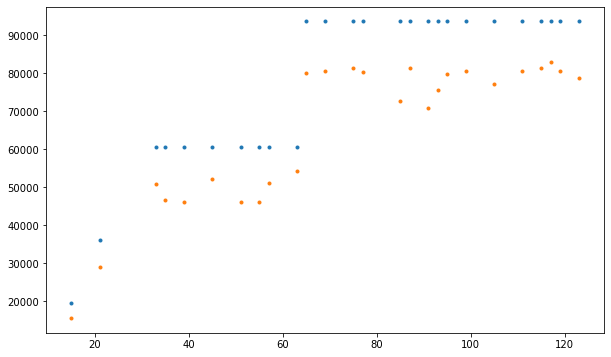

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(compl['depth'].keys(), [dep(N.bit_length()) for N in compl['depth'].keys()], '.')
ax.plot(compl['depth'].keys(), compl['depth'].values(), '.')


In [40]:
compl = {'depth': [15270, 15270, 15594, 15274, 15590, 15594, 28898, 28906, 29226, 27802, 29298, 28926, 28130, 28910, 29238, 
                   29294, 50423, 50924, 50902, 51338, 51037, 45995, 51001, 51296, 50912, 50457, 51296, 50888, 46245, 50912, 
                   51338, 51039, 51116, 50916, 51126, 51530, 51520, 45940, 46642, 51584, 51806, 51520, 46962, 51818, 51906, 
                   51144, 51884, 46672, 51712, 51862, 52092, 46926, 46256, 52042, 51726, 51892, 50416, 50788, 46480, 51034, 
                   46454, 50828, 50942, 46132, 51074, 51352, 51218, 50418, 51062, 51366, 46128, 51036, 51434, 46912, 50952, 
                   46920, 51392, 51216, 51402, 51796, 51890, 46638, 52420, 51924, 52198, 52154, 46676, 46256, 52092, 51428, 
                   46076, 46972, 52248, 52142, 51950, 51868, 46988, 51936, 52390, 52086, 46014, 45902, 47458, 47406, 46164, 
                   47372, 47280, 45932, 47270, 45674, 46724, 47360, 47452, 47370, 46810, 46048, 47304, 47530, 47362, 46168, 
                   46256, 47482, 46522, 47428, 47448, 46754, 47508, 47418, 46526, 46780, 51136, 52162, 51520, 52098, 51948, 
                   51880, 52278, 46668, 51786, 51542, 52008, 51850, 52342, 51942, 46128, 46718, 52158, 52016, 52004, 51204, 
                   51872, 52004, 46702, 46132, 52004, 52242, 51776, 52226, 52230, 51672, 46710, 52114, 52376, 52388, 52312, 
                   52226, 52328, 51936, 50473, 51086, 51386, 54068, 53641, 50902, 54029, 51325, 51498, 51082, 51089, 45980, 
                   51371, 51440, 51086, 54062, 51082, 50494, 53986, 51203, 51552, 51328, 46116, 50910, 51307, 51082, 51224, 
                   53969, 51115, 54068, 53728, 51522, 51569, 51094, 45214, 45198, 54356, 45414, 54380, 54534, 54412, 45206, 
                   54372, 54412, 54380, 54554, 54530, 54530, 54412, 54554, 46096, 45210, 54380, 54554, 54392, 54348, 54404, 
                   54554, 54554, 54554, 46104, 54554, 54384, 54550, 46312, 54530, 46096, 46104, 78660, 79839, 79195, 79853, 
                   79408, 70868, 79746, 79939, 71094, 70274, 79625, 79908, 71298, 79971, 71554, 79908, 79952, 79994, 71379, 
                   79402, 79836, 71575, 79427, 78678, 71278, 79825, 79491, 71130, 80087, 80039, 80235, 71330, 80082, 71344, 
                   80069, 79274, 70466, 71366, 80266, 79802, 70909, 79522, 80228, 79613, 80214, 79439, 79954, 80794, 80568, 
                   81904, 80678, 81892, 80714, 81712, 80624, 81682, 81670, 81388, 81052, 70296, 80956, 80706, 80658, 81682, 
                   81362, 80680, 81002, 79990, 80718, 81058, 81422, 80638, 81282, 80650, 70604, 81380, 81656, 80838, 82008, 
                   80880, 82016, 80984, 82220, 81252, 82208, 80836, 81640, 80982],
         'single': [16255, 16255, 16525, 16255, 16525, 16525, 34428, 34428, 34698, 33456, 34752, 34428, 33726, 34428, 34698, 
                    34752, 65624, 66033, 66003, 66360, 66172, 61636, 66112, 66360, 66033, 65624, 66359, 66003, 61855, 66033, 
                    66359, 66113, 66169, 66033, 66138, 66460, 66489, 61627, 62250, 66489, 66705, 66460, 62493, 66705, 66786, 
                    66138, 66757, 62250, 66624, 66759, 66921, 62491, 61899, 66919, 66624, 66786, 65517, 65841, 62088, 66029, 
                    62088, 65841, 65949, 61790, 66057, 66300, 66192, 65517, 66057, 66299, 61791, 66029, 66354, 62465, 65949, 
                    62466, 66353, 66192, 66408, 66759, 66813, 62250, 67245, 66813, 67083, 67029, 62250, 61899, 66975, 66408, 
                    61737, 62520, 67083, 67029, 66840, 66759, 62520, 66840, 67245, 66975, 61737, 61629, 62952, 62924, 61845, 
                    62898, 62789, 61629, 62789, 61413, 62331, 62870, 62924, 62871, 62385, 61737, 62843, 63005, 62843, 61845, 
                    61899, 62952, 62142, 62951, 62951, 62331, 63005, 62897, 62142, 62385, 66165, 67029, 66462, 66948, 66786, 
                    66786, 67110, 62277, 66705, 66462, 66867, 66705, 67137, 66786, 61791, 62277, 67029, 66867, 66840, 66165, 
                    66786, 66867, 62277, 61791, 66867, 67029, 66624, 67029, 67056, 66624, 62277, 66948, 67191, 67191, 67110, 
                    67056, 67137, 66840, 65634, 66149, 66419, 68637, 68312, 65987, 68609, 66364, 66527, 66149, 66148, 61659, 
                    66365, 66420, 66149, 68611, 66149, 65636, 68556, 66282, 66528, 66312, 61768, 65987, 66286, 66149, 66308, 
                    68555, 66151, 68637, 68314, 66528, 66529, 66149, 61197, 61197, 68838, 61197, 68838, 68973, 68838, 61197, 
                    68838, 68838, 68838, 68973, 68973, 68973, 68838, 68973, 61953, 61197, 68838, 68973, 68838, 68838, 68838, 
                    68973, 68973, 68973, 61953, 68973, 68838, 68973, 61953, 68973, 61953, 61953, 111810, 112812, 112301, 
                    112839, 112434, 104818, 112760, 112845, 105003, 104271, 112626, 112868, 105164, 112921, 105381, 112815, 
                    112868, 112927, 105221, 112434, 112758, 105382, 112463, 111810, 105164, 112783, 112513, 105004, 113006, 
                    112975, 113113, 105165, 113003, 105169, 112978, 112297, 104432, 105220, 113143, 112792, 104813, 112514, 
                    113138, 112626, 113111, 112463, 112812, 113513, 113323, 114404, 113406, 114402, 113403, 114241, 113323, 
                    114242, 114214, 113999, 113699, 104338, 113649, 113403, 113406, 114214, 113972, 113377, 113673, 112809, 
                    113402, 113703, 113998, 113378, 113890, 113406, 104608, 113971, 114215, 113511, 114510, 113538, 114512, 
                    113646, 114674, 113890, 114673, 113541, 114213, 113676], 
         'cnot': [13116, 13116, 13356, 13116, 13356, 13356, 27078, 27078, 27318, 26214, 27366, 27078, 26454, 27078, 27318, 
                  27366, 50730, 51090, 51066, 51378, 51210, 47202, 51162, 51378, 51090, 50730, 51378, 51066, 47394, 51090, 
                  51378, 51162, 51210, 51090, 51162, 51450, 51474, 47154, 47706, 51474, 51666, 51450, 47922, 51666, 51738, 
                  51162, 51714, 47706, 51594, 51714, 51858, 47922, 47394, 51858, 51594, 51738, 50610, 50898, 47562, 51066, 
                  47562, 50898, 50994, 47298, 51090, 51306, 51210, 50610, 51090, 51306, 47298, 51066, 51354, 47898, 50994, 
                  47898, 51354, 51210, 51402, 51714, 51762, 47706, 52146, 51762, 52002, 51954, 47706, 47394, 51906, 51402, 
                  47250, 47946, 52002, 51954, 51786, 51714, 47946, 51786, 52146, 51906, 47250, 47154, 48330, 48306, 47346, 
                  48282, 48186, 47154, 48186, 46962, 47778, 48258, 48306, 48258, 47826, 47250, 48234, 48378, 48234, 47346, 
                  47394, 48330, 47610, 48330, 48330, 47778, 48378, 48282, 47610, 47826, 51186, 51954, 51450, 51882, 51738, 
                  51738, 52026, 47730, 51666, 51450, 51810, 51666, 52050, 51738, 47298, 47730, 51954, 51810, 51786, 51186, 
                  51738, 51810, 47730, 47298, 51810, 51954, 51594, 51954, 51978, 51594, 47730, 51882, 52098, 52098, 52026, 
                  51978, 52050, 51786, 50730, 51186, 51426, 53394, 53106, 51042, 53370, 51378, 51522, 51186, 51186, 47202, 
                  51378, 51426, 51186, 53370, 51186, 50730, 53322, 51306, 51522, 51330, 47298, 51042, 51306, 51186, 51330, 
                  53322, 51186, 53394, 53106, 51522, 51522, 51186, 46770, 46770, 53562, 46770, 53562, 53682, 53562, 46770, 
                  53562, 53562, 53562, 53682, 53682, 53682, 53562, 53682, 47442, 46770, 53562, 53682, 53562, 53562, 53562, 
                  53682, 53682, 53682, 47442, 53682, 53562, 53682, 47442, 53682, 47442, 47442, 85152, 86040, 85584, 86064, 
                  85704, 78960, 85992, 86064, 79128, 78480, 85872, 86088, 79272, 86136, 79464, 86040, 86088, 86136, 79320, 
                  85704, 85992, 79464, 85728, 85152, 79272, 86016, 85776, 79128, 86208, 86184, 86304, 79272, 86208, 79272, 
                  86184, 85584, 78624, 79320, 86328, 86016, 78960, 85776, 86328, 85872, 86304, 85728, 86016, 86640, 86472, 
                  87432, 86544, 87432, 86544, 87288, 86472, 87288, 87264, 87072, 86808, 78480, 86760, 86544, 86544, 87264, 
                  87048, 86520, 86784, 86016, 86544, 86808, 87072, 86520, 86976, 86544, 78720, 87048, 87264, 86640, 87528, 
                  86664, 87528, 86760, 87672, 86976, 87672, 86664, 87264, 86784]}

In [43]:
depth = {}
single = {}
cnot = {}
i = 0
for N in range(2, 70):
    if find_int_pow(N)[1] == 1 and N%2 != 0 and is_prime(N)==False:
        depth[N] = []
        single[N] = []
        cnot[N] = []
        for a in range(2, N-1):
            if gcd(a, N)[1] == 1:
                depth[N].append(compl['depth'][i])
                single[N].append(compl['single'][i])
                cnot[N].append(compl['cnot'][i])
                i += 1

Text(0, 0.5, 'egy qubites kapuk száma')

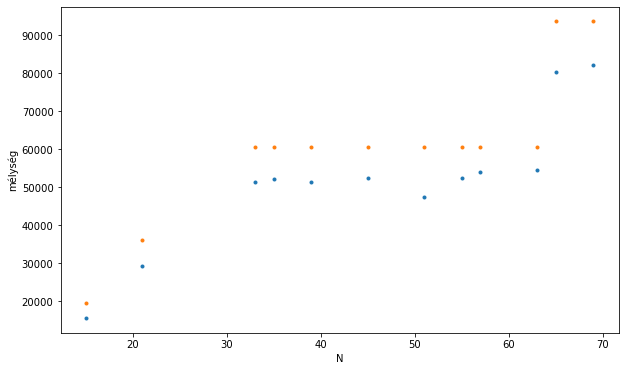

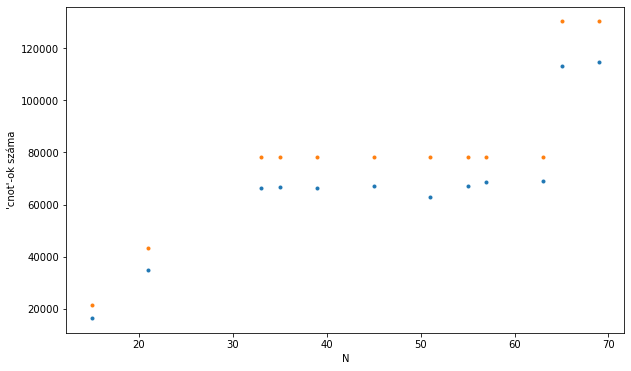

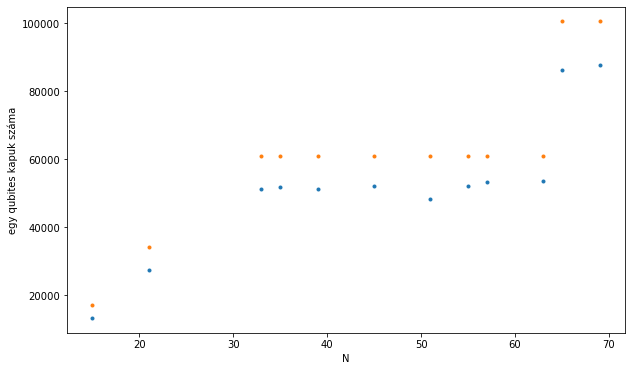

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(depth.keys(), [max(depth[N]) for N in depth.keys()], '.')
ax.plot(depth.keys(), [dep(N.bit_length()) for N in depth.keys()], '.')
ax.set_xlabel('N')
ax.set_ylabel('mélység')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(single.keys(), [max(single[N]) for N in single.keys()], '.')
ax.plot(single.keys(), [sing(N.bit_length()) for N in single.keys()], '.')
ax.set_ylabel("'cnot'-ok száma")
ax.set_xlabel('N')

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cnot.keys(), [max(cnot[N]) for N in cnot.keys()], '.')
ax.plot(cnot.keys(), [cx(N.bit_length()) for N in cnot.keys()], '.')
ax.set_xlabel('N')
ax.set_ylabel('egy qubites kapuk száma')


In [9]:
# nem végleges, nem működik jól ('feed-forward'-ra lenne szükség a megvalósításhoz)
def Shor_phase_est2(a, N, device=Aer.get_backend('qasm_simulator')): # uses semi classical QFT_dg,
    n = N.bit_length()
    result = []
    for i in range(2*n+3):
        qc = QuantumCircuit(2*n+3, 1)
        qc.x(1)
        qc.h(0)
        mod = two_pow_mod(a, 2*n+2-i, N)
        qc.append(c_U(mod, N), range(2*n+3))
        qc.h(0)
        num = 0
        for j in range(len(result)):
            num += result[j]*(2**j)
        qc.p(-num*np.pi/2**i, 0)
        qc.measure(0, 0)
        job = execute(qc, device, shots=1)
        job_monitor(job)
        counts = job.result().get_counts()
        result.append(int(list(counts)[0]))
        print(result)
    return result # bits are in reversed order

### N=15

In [77]:
N = 15
n = N.bit_length()
a = 7
qc = QuantumCircuit(4, 4)
qc.append(qft(n), range(4))
qc.append(F_add(n, a), range(n))
qc.append(qft(n).inverse(), range(n))
qc.measure(range(4), range(4))

sc = qk.compiler.transpile(qc, real2, optimization_level=3)
print(sc.depth(), sc.count_ops())

101 OrderedDict([('rz', 72), ('sx', 63), ('cx', 46), ('measure', 4), ('barrier', 1)])


In [78]:
job = execute(sc, real2, shots=5)
job_monitor(job)
result = job.result()
counts = result.get_counts()

Job Status: job has successfully run


In [79]:
print(counts)

{'0010': 1, '0111': 1, '1010': 1, '1100': 2}


## Bitstring eloszlás

In [21]:
N = 21
a = 5
n = N.bit_length()
def circ(cbits):
    qc1 = QuantumCircuit(4*n+5,2*n+cbits)
    qc1.append(Shor_phase_est(a, N, cbits=cbits), range(4*n+2+cbits))
    qc1.measure(range(2*n+cbits), range(2*n+cbits))
    return qc1
    
circs = [circ(i) for i in range(-4, 4)]

In [22]:
simulator = Aer.get_backend('qasm_simulator')
job1 = execute(circs, simulator, shots=1024)
result1 = job1.result()
counts1 = result1.get_counts()

In [56]:
c = []
for i in range(len(counts1)):    
    c.append(list(counts1[i]))
    #print(counts1[i], len(counts1[i]))

len(counts1)
m = len(list(counts1[-1])[0])-2*n + 1

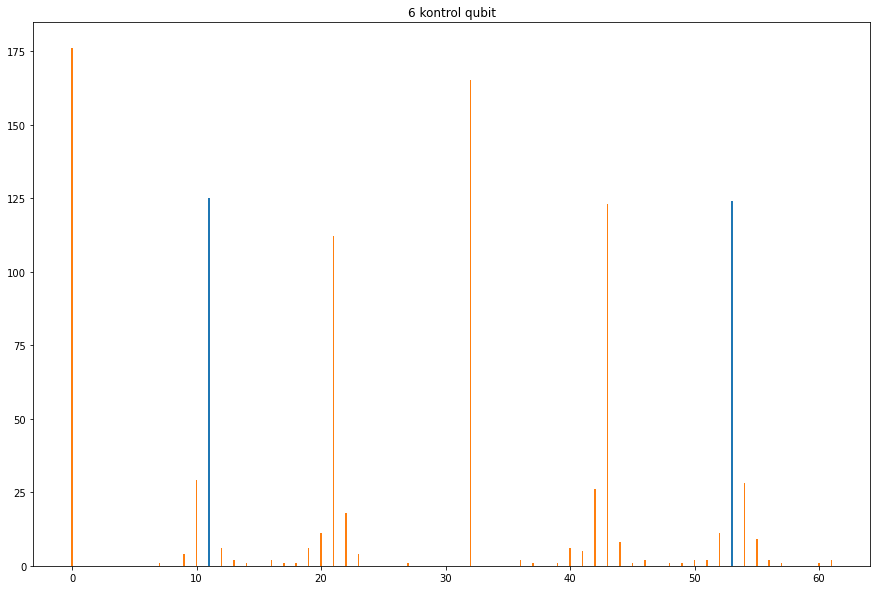

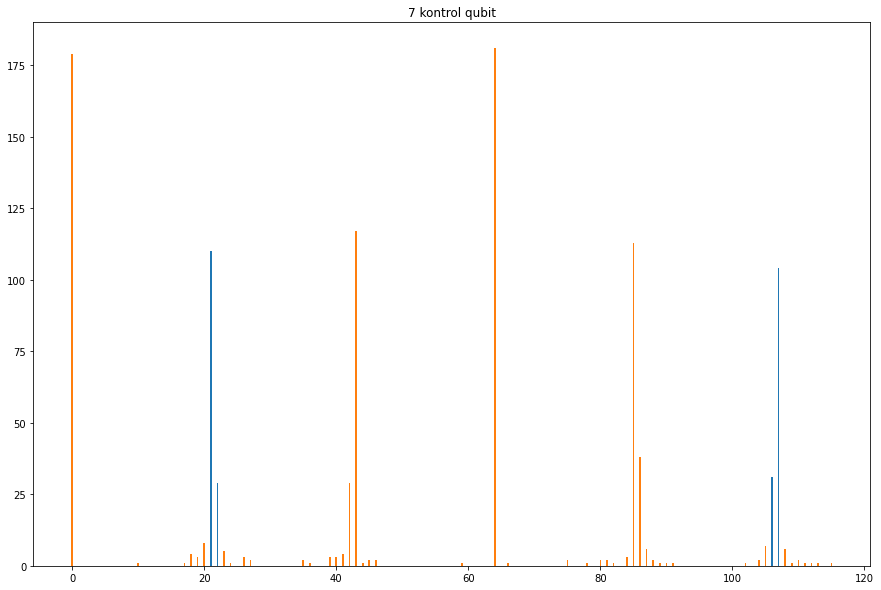

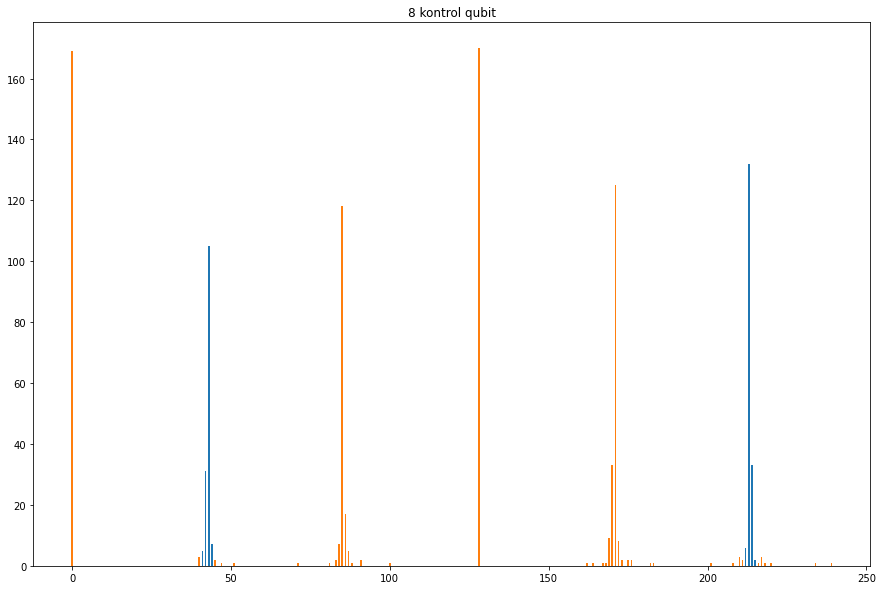

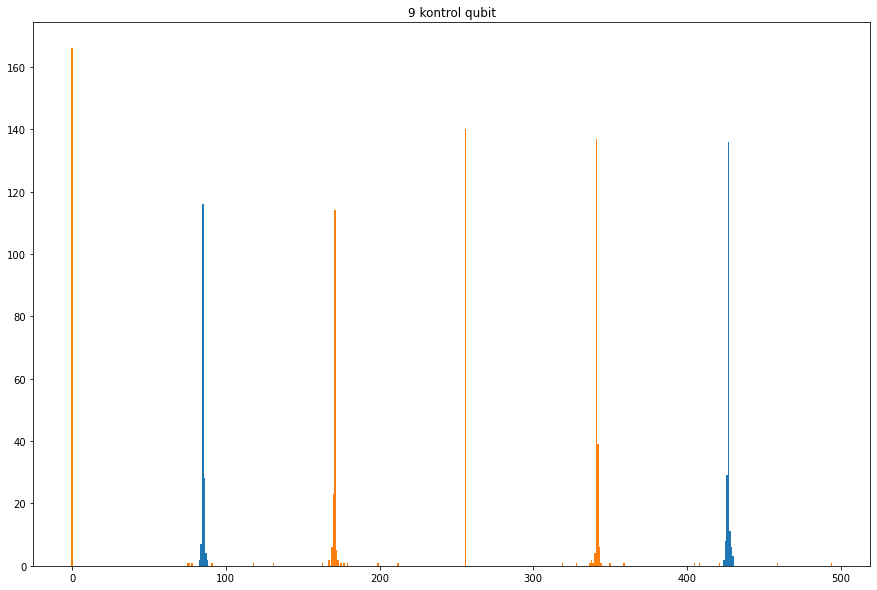

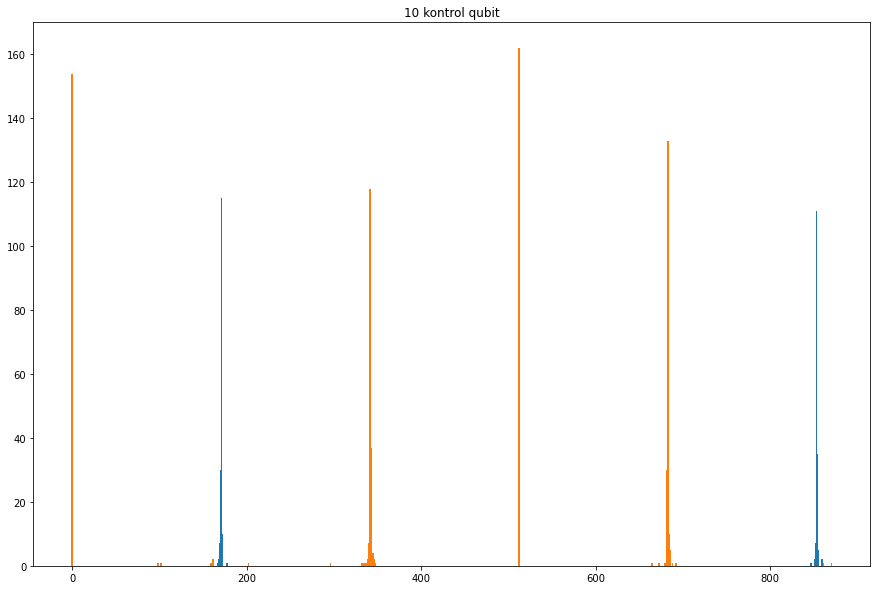

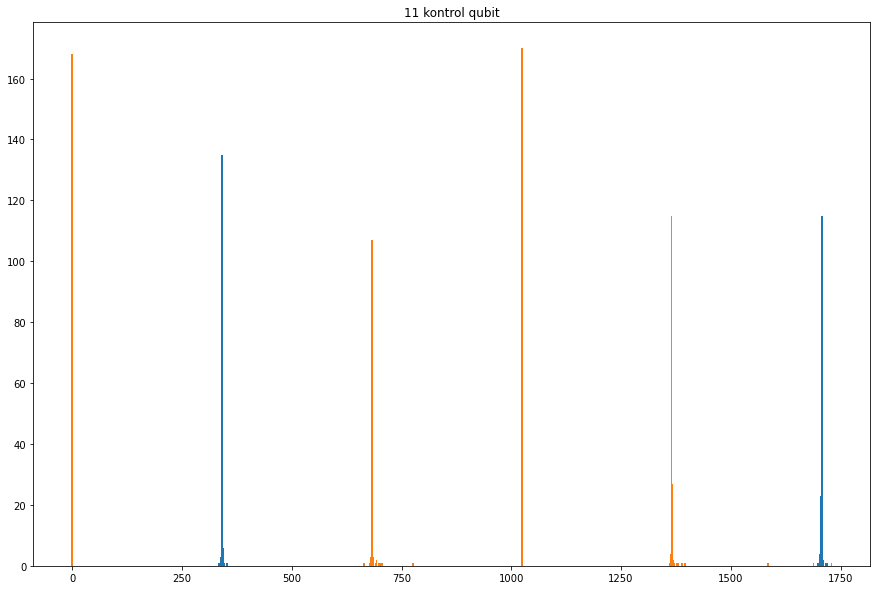

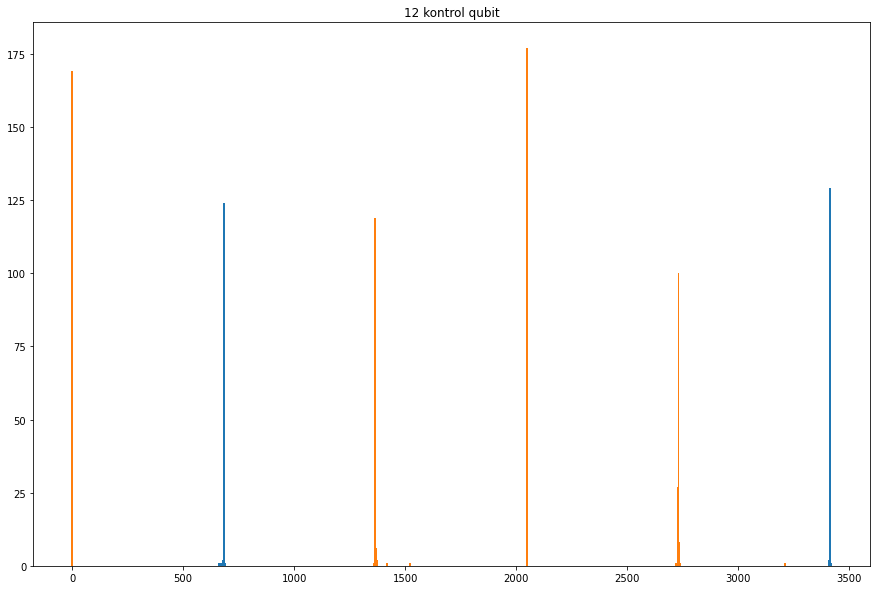

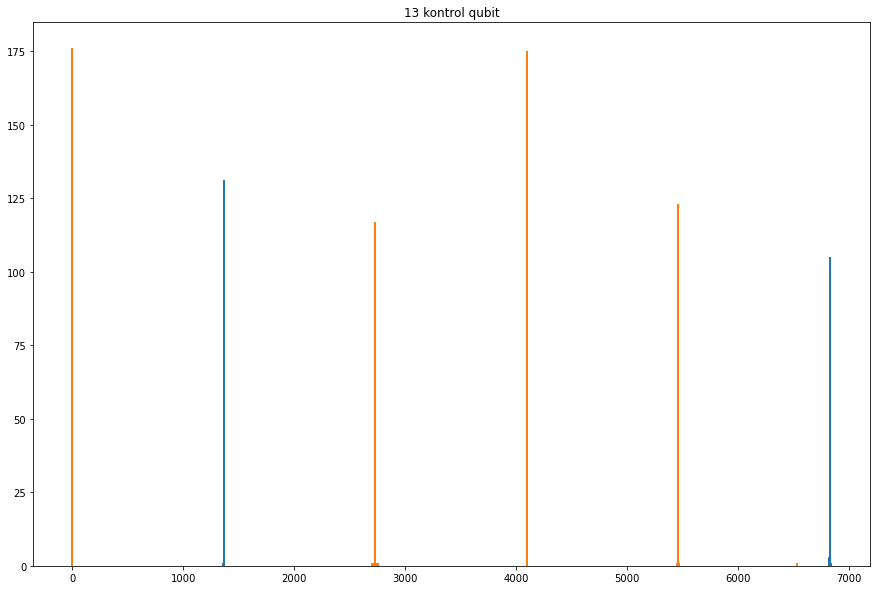

In [58]:
b = 5
r = order_classic(b, N)
for cbits in range(len(counts1)):
    frac = {}
    num = {} # adott bitstring mérésének száma
    nbits = 2*n+cbits-4
    a = np.zeros(len(c[cbits]))
    for j in range(len(c[cbits])):
        bits = list(c[cbits])[j]
        for i in range(nbits):
            a[j] += int(bits[i])*2**(nbits-1-i)
        f = a[j]/2**(nbits)
        if a[j] in num.keys():
            num[a[j]] = num[a[j]] + counts1[cbits][bits]
        else:
            num[a[j]] = counts1[cbits][bits]
        if f in frac.keys():
            frac[f] = frac[f] + counts1[cbits][bits]
        else:
            frac[f] = counts1[cbits][bits]
    M = 2**nbits
    success = []
    fail = []
    for i in range(M):
        m, q = convergents(cont_frac(i, M))
        q = np.array(q, dtype = int)
        r1 = max(q[q <= N])
        if i in num.keys():
            if r == r1:
                success.append(i)
            else:
                fail.append(i)
    success = np.array(success)
    fig, ax = plt.subplots(figsize=(15,10))
    ax.bar(success, [num[i] for i in success], width=2*2**(cbits-4))
    ax.bar(fail, [num[i] for i in fail], width=2*2**(cbits-4))
    ax.set_title('%i kontrol qubit' %nbits)

## Számelméleti segédfüggvények

In [12]:
def cont_frac(p, q, a=[]):
    b = list(np.copy(a))
    b.append(p//q)
    if p%q == 0:
        return b
    return cont_frac(q, p-(p//q)*q, b)

def convergents(a):
    if len(a) == 1:
        return a[0], 1
    p = [a[0], 1+a[0]*a[1]]
    q = [1, a[1]]
    for i in range(2, len(a)):
        p.append(a[i]*p[i-1]+p[i-2])
        q.append(a[i]*q[i-1]+q[i-2])
    return p, q

def order_classic(a, N): 
    if gcd(a, N)[1] != 1:
        raise ValueError("a and N have to be coprime")
    s = 1
    i = 0
    while i == 0 or s != 1:
        s = (a*s) % N
        i += 1
    return i

In [13]:
def int_nth_root(A, n): #calculate floor of nth root of A
    if A<0:
        if n%2 == 0:
            raise ValueError
        return -int_nth_root(-A,n)
    if A==0:
        return 0
    n1 = n-1
    if A.bit_length() < 1024: # float(n) safe from overflow
        xk = int( round( pow(A,1.0/n) ) )
        xk = ( n1*xk + A//pow(xk,n1) )//n # Ensure xk >= floor(nthroot(A)).
    else:
        xk = 1 << -(-A.bit_length()//n) # 1 << sum(divmod(A.bit_length(),n))
                                        # power of 2 closer but greater than the nth root of A
    while True:
        d = A // pow(xk,n1)
        if xk <= d:
            return xk
        xk = (n1*xk + d)//n

In [14]:
def two_pow(A, k): #computes A**(2**k), A: L bit int, k < log(L)
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 
    return result  # max O(L^2*log(L)) operations


def int_pow(A, n): #computes A**n in polynomal time, A: L bit int, n < L
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow(A, i)
    return result #max O(log(L)*L^2*log(L))

In [15]:
def two_pow_mod(A, k, N): #computes A**(2**k) mod N, A: L bit int, k < log(L)
    result = np.copy(A)
    for i in range(k): # k multiplying operations
        result = result**2 % N
    return result  # max O(L^2*log(L)) operations

def int_pow_mod(A, n, N): #computes A**n mod N in polynomal time, A: L bit int, n < L
    n_bin = list(bin(n))
    index = n_bin.index('b')
    n_bin = n_bin[index+1:]
    l = len(n_bin) # l < log(L)
    result = 1
    for i in range(l):
        bit = int(n_bin[l-i-1])
        if bit == 1:
            result = result*two_pow_mod(A, i, N) % N
    return result # max O(log(L)*L^2*log(L))

In [16]:
def find_int_pow(N):
    n = N.bit_length()
    for i in range(2, n):
        a = int_nth_root(N, i)
        if int_pow(a, i) == N:
            return a, i
    return N, 1

In [17]:
# determines if n is probably-prime or composite using miller rabin test. Tests k times
def is_prime(n, k=20): # miller-rabin test
    if n == 2:
        return True
    for _ in range(k):
        witness = 1
        a = random.randint(2, n-1)
        if gcd(a, n)[1] != 1:
            return False
        d = n-1
        r = 0
        while d % 2 == 0:
            d = d//2
            r += 1
        s = int_pow_mod(a, d, n)
        if s == 1:
            witness = 0
        for i in range(r):
            if s == n-1:
                witness = 0
            s = s**2 % n
        if witness == 1:
            return False
    return True

## Periódus kereső és Shor algoritmusok

In [18]:
def order(a, N, device = Aer.get_backend('qasm_simulator'), cbits=3, basis_gates=None, noise_model=None): # order of a mod N 
    n = N.bit_length()
    qc = QuantumCircuit(4*n+5,2*n+cbits)
    qc.append(Shor_phase_est(a, N, cbits=cbits), range(4*n+2+cbits))
    qc.measure(range(2*n+cbits), range(2*n+cbits))
    m = 0
    num = 1
    i = 0
    while (m != 1 or num == 0) and i < 50:
        job = execute(qc, device, shots=1, basis_gates=basis_gates, noise_model=noise_model)
        counts = job.result().get_counts()
        print(counts)
        #job_monitor(job)
        estimate = 0
        bits = list(list(counts)[0])
        for j in range(2*n+cbits):
            estimate += int(bits[j])*2**(2*n+cbits-1-j)
        p, q = convergents(cont_frac(estimate, 2**(2*n+cbits)))
        q = np.array(q, dtype = int)
        p = np.array(p, dtype = int)
        r = max(q[q <= N])
        num = max(p[q <= N])
        m = int_pow_mod(a, r, N)
        
        
        # ha a periódus páros számú többszörösét találtuk meg (valami hiba folytán), akkor módosítani kell
        while int_pow_mod(a, r//2, N) == 1 and r//2 != 0:
            m = int_pow_mod(a, r//2, N)
            r = r//2
        i += 1
        print('r:',r)
        print('i:', i)
        if i == 50:
            raise RuntimeError
        
    return r, i

In [19]:
def Shor(N, cbits=3): # Shor's algorithm, returns list with prime factors
    factors = [] # we collect the factors here
    
    if is_prime(N, 20) == True: # cheking if N is prime
        return [N]
    
    if N%2 == 0: # cheking if N is even
        factors = [2] + Shor(N//2)
        return factors
    
    base, power = find_int_pow(N)
    if power != 1: # cheking if N is a power of a prime
        factors = power * Shor(base)
        factors.sort()
        return factors
    
    r = 1
    while r % 2 != 0 or int_pow_mod(a, r//2, N) == N-1:
        a = random.randint(2, N-2)
        print('a:',a)
        if gcd(a, N)[1] != 1:  #cheking if N and a are coprime
            devisor = gcd(a, N)[1]
            factors = Shor(devisor) + Shor(N//devisor)
            factors.sort()
            return factors
        
        r, i = order(a, N, cbits=cbits) # returns order of 'a' mod N (quantum part)
        h = int_pow_mod(a, r//2, N)
        dev1 = gcd(N, h-1)[1]
        dev2 = gcd(N, h+1)[1]
        if (N % dev2 == 0) and (dev2 != 1) and (N != dev2):
            factors = Shor(dev2) + Shor(N//dev2)
            factors.sort()
            return factors
        elif (N % dev1) == 0 and (dev1 != 1) and (N != dev1):
            factors = Shor(dev1) + Shor(N//dev1)
            factors.sort()
            return factors

In [75]:
N = 15
a = 7
n = N.bit_length()
cbits = 3-2*n
qc = QuantumCircuit(4*n+2+cbits, 3)
qc.append(Shor_phase_est(a, N, cbits=cbits), range(4*n+2+cbits))
qc.measure(range(3), range(3))

In [111]:
job = execute(qc, simulator ,shots=50)
result = job.result()
counts = result.get_counts()

In [115]:
print(counts)

{'010': 14, '100': 13, '000': 14, '110': 9}


In [126]:
Shor(15, cbits=2-2*n)

a: 13
{'00': 1}
r: 1
i: 1
{'11': 1}
r: 4
i: 2


[3, 5]

## Szükséges futtatások száma

In [21]:
# Error probabilities
prob_1 = 0.00001  # 1-qubit gate
prob_2 = 0.0001   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

l = []
N = 15
for j in range(50):
    a = random.randint(2, N-1)
    while gcd(a, N)[1] != 1:
        a = random.randint(2, N-1)
    r, i = order(a, N, basis_gates=basis_gates, noise_model=noise_model)
    l.append(i)
    if j%5==0:
        print(l)
print(l)

r: 2
i: 1
r: 1
i: 2
r: 4
i: 3
[3]
r: 1
i: 1
r: 1
i: 2
r: 2
i: 3
r: 4
i: 1
r: 4
i: 1
r: 2
i: 1
r: 2
i: 1
r: 4
i: 2
[3, 3, 1, 1, 1, 2]
r: 4
i: 1
r: 4
i: 1
r: 4
i: 1
r: 2
i: 1
r: 2
i: 1
[3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1]
r: 4
i: 1
r: 1
i: 1
r: 2
i: 2
r: 4
i: 1
r: 4
i: 1
r: 7
i: 1
r: 4
i: 2
[3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2]
r: 2
i: 1
r: 1
i: 2
r: 2
i: 3
r: 7
i: 4
r: 4
i: 5
r: 2
i: 1
r: 1
i: 2
r: 6
i: 3
r: 5
i: 4
r: 4
i: 5
r: 4
i: 1
r: 2
i: 1
r: 1
i: 1
r: 2
i: 2
[3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 5, 5, 1, 1, 2]
r: 2
i: 1
r: 3
i: 1
r: 1
i: 2
r: 1
i: 3
r: 1
i: 4
r: 7
i: 5
r: 2
i: 6
r: 2
i: 1
r: 6
i: 2
r: 4
i: 3
r: 2
i: 1
r: 1
i: 1
r: 2
i: 2
r: 4
i: 3
[3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 5, 5, 1, 1, 2, 1, 6, 3, 1, 3]
r: 4
i: 1
r: 4
i: 1
r: 11
i: 1
r: 4
i: 2
r: 6
i: 1
r: 2
i: 2
r: 15
i: 3
r: 4
i: 4
r: 2
i: 1
[3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 5, 5, 1, 1, 2, 1, 6, 3, 1, 3, 1, 1, 2, 4, 1]
r: 2
i: 1
r: 4
i: 1
r: 2
i: 1
r: 4
i: 2
r: 4
i: 1
r: 2


In [20]:
l15_1 = [2, 6, 3, 2, 3, 5, 1, 10, 6, 4, 1, 1, 10, 1, 3, 2, 2, 12, 2, 1, 
         4, 9, 4, 1, 3, 1, 1, 3, 3, 1, 3, 4, 3, 1, 1, 4, 3, 9, 3, 6,
         2, 1, 1, 1, 1, 1, 6, 2, 1, 1 ,2, 7, 4, 6, 4, 3, 4, 3, 4, 1,
         5, 7, 1, 1, 2, 3, 3, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 
         1, 5, 1, 3, 4, 2, 3, 3, 1, 1, 2, 6, 1, 8, 1, 4, 4, 4, 4, 6, 
         6, 1, 2, 3, 1, 3, 1, 4, 1, 4, 1, 5, 6, 1, 1, 1, 1, 4, 1, 3, 
         1, 1, 1, 4, 1, 1, 4, 2, 4, 2, 2, 1, 1, 6, 2, 1, 3, 6, 1, 2, 
         1, 4, 5, 3, 1, 7, 2, 2, 2, 6, 1, 1, 1, 2, 1, 2, 3, 1, 4, 6,  
         8, 3, 2, 4, 2, 1, 3, 2, 1, 3, 3, 5, 11, 2, 1, 3, 1, 11, 2, 1, 
         1, 4, 3, 1, 8, 2, 1, 1, 2, 2, 4, 1, 3, 3, 1, 1, 2, 2, 6, 1,
         1, 2, 1, 1, 2, 3, 2, 3, 1, 3, 4, 2, 1, 1, 1, 2, 1, 2, 1, 3, 
         4, 1, 4, 2, 1, 1, 2, 4, 2, 2, 2, 1, 6, 1, 1, 2, 2, 1, 3, 1, 
         1, 1, 5, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 5, 
         5, 1, 1, 2, 1, 6, 3, 1, 3, 1, 1, 2, 4, 1, 1, 1, 2, 1, 2, 1, 
         1, 6, 1, 2, 1, 1, 2, 1, 4, 2, 4, 2, 1]


l21_1 = [4, 1, 10, 3, 5, 1, 3, 1, 4, 9, 3, 4, 9, 3, 1, 7, 2, 1, 1, 10, 
         4, 2, 15, 5, 1, 12, 3, 2, 3, 2, 1, 4, 1, 1, 1, 2]

In [21]:

l15=[4, 1, 1, 2, 5, 1, 2, 2, 1, 2, 1, 1, 4, 2, 1, 2, 1, 1, 1, 1, 
     1, 2, 6, 2, 3, 2, 4, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 3, 4, 1, 
     1, 2, 4, 1, 1, 1, 1, 1, 1, 2, 3, 5, 3, 1, 1, 1, 1, 1, 1, 1, 
     1, 4, 6, 2, 6, 1, 1, 2, 2, 2, 2, 1, 1, 5, 1, 1, 1, 4, 1, 1, 
     3, 2, 4, 1, 3, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 
     1, 1, 1, 2, 1, 1, 2, 4, 1, 2, 1, 3, 1, 6, 1, 1, 1, 1, 1, 11, 
     2, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 1, 3, 2, 3, 1, 1, 1, 2, 3, 
     1, 1, 3, 2, 1, 2, 4, 2, 1, 1]

l21=[1, 5, 4, 1, 4, 1, 1, 9, 2, 1, 3, 1, 2, 1, 4, 4, 2, 3, 1, 2, 
     4, 1, 3, 2, 8, 1, 12, 9, 3, 1, 4, 4, 2, 1, 1, 1, 3, 3, 2, 1, 
     3, 2, 8, 2, 1, 1, 2, 1, 2, 1, 1, 1, 6, 1, 4, 1, 3, 2, 2, 1, 
     1, 2, 7, 4, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 
     1, 1, 6, 2, 2, 2, 1, 1, 3, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 
     1, 1, 1, 1, 3, 3, 1, 1, 5, 2, 2, 1, 2, 3, 2, 1, 1, 1, 1, 2, 
     3, 1, 3, 8, 1, 4, 1, 2, 1, 1, 1, 2, 6, 3, 1, 1, 2, 2, 1, 1, 
     1, 1, 5, 1, 3, 1, 2, 3, 3, 8]
len(l15_1)

293

(array([123.,   0.,  57.,   0.,  40.,   0.,  33.,   0.,  10.,   0.,  17.,
          0.,   3.,   0.,   3.,   0.,   2.,   0.,   2.,   0.,   2.,   0.,
          1.]),
 array([ 0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,  4.75,
         5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,  9.25,
         9.75, 10.25, 10.75, 11.25, 11.75, 12.25]),
 <BarContainer object of 23 artists>)

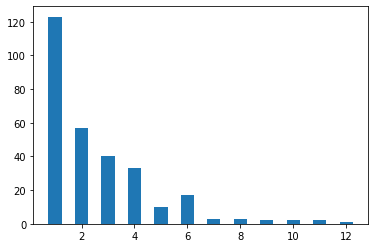

In [22]:
# az order függvény próbálkozásainak száma a "sikerig" N=21 esetén zajos szimulátorral
plt.hist(l15_1, bins=np.arange(0.75, max(l15_1)+0.75, 0.5)) 

(array([84.,  0., 31.,  0., 16.,  0., 11.,  0.,  3.,  0.,  4.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,  4.25,  4.75,
         5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,  9.25,
         9.75, 10.25, 10.75, 11.25]),
 <BarContainer object of 21 artists>)

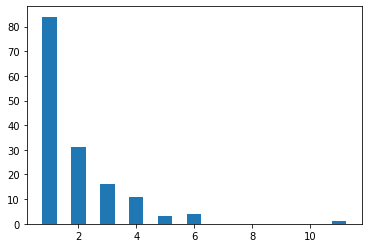

In [23]:
plt.hist(l15, bins=np.arange(0.75, max(l15)+0.75, 0.5)) # az order függvény próbálkozásainak száma a "sikerig" N=15 esetén

In [24]:
backend = provider.get_backend('ibmq_armonk')
noise_model_real = NoiseModel.from_backend(backend)

In [30]:
# Error probabilities
prob_1 = 0.000005  # 1-qubit gate
prob_2 = 0.00005   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'rz', 'sx', 'x'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates


In [31]:
# Make a circuit
N = 21
a = 5

n = N.bit_length()
qc = QuantumCircuit(4*n+5, 4*n+5)
qc.append(Shor_phase_est(a, N), range(4*n+5))
qc.measure(range(2*n+3), range(2*n+3))

In [ ]:
# Perform a noise simulation
# = qk.compiler.transpile(circ, basis_gates=basis_gates)
result = execute(qc, Aer.get_backend('qasm_simulator')
                , basis_gates=basis_gates
                , noise_model=noise_model
                , shots=20
                ).result()
counts = result.get_counts(0)

In [ ]:
dict = {}
for i in list(counts):
    num = 0
    for j in range(2*n+3):
        num += int(i[-j-1])*2**j
    frac = convergents(cont_frac(num, 2**(2*n+3)))
    frac = np.array(frac)
    r = max(frac[1][frac[1]<N])
    if r in dict.keys():
        dict[r] += counts[i]
    else: dict[r]=counts[i]
plot_histogram(counts)
print(dict.keys())

## Áramkör topológiája

In [24]:
n = 4
K =1
nodes = K + 2*n + 2
lines = K*(K-1)/2 + K*(2*n+1) + 3*n*(n+1)/2 + n+1
full = nodes*(nodes-1)/2
print(full, lines)
for n in range(2, 100):
    K = 2*n+3
    nodes = K + 2*n + 2
    lines = K*(K-1)/2 + K*(2*n+1) + 3*n*(n+1)/2 + n+1
    full = nodes*(nodes-1)/2
    print(lines/full)

55.0 44.0
0.8717948717948718
0.8897058823529411
0.9
0.9066666666666666
0.9113300492610837
0.9147727272727273
0.9174174174174174
0.9195121951219513
0.9212121212121213
0.9226190476190477
0.9238026124818578
0.924812030075188
0.9256830601092896
0.9264423076923077
0.9271099744245525
0.9277016742770168
0.9282296650717703
0.9287037037037037
0.9291316526610645
0.9295199182839632
0.9298737727910238
0.9301975945017182
0.9304950495049505
0.9307692307692308
0.9310227658851512
0.9312579013906448
0.9314765694076039
0.9316804407713498
0.9318709677419355
0.9320494186046512
0.9322169059011164
0.9323744096178618
0.9325227963525836
0.9326628352490421
0.9327952113187012
0.932920536635707
0.9330393597909521
0.9331521739130435
0.9332594235033259
0.9333615102845872
0.933458798225568
0.9335516178736518
0.9336402701043585
0.9337250293772033
0.933806146572104
0.9338838514680483
0.9339583549155703
0.9340298507462687
0.9340985174557628
0.9341645196908355
0.9342280095668349
0.9342891278375149
0.9343480049362403
0.